In [25]:
%run import_modules.py  
%matplotlib inline

# For DNN modeling
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.initializers import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.utils import * # model_to_dot, to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import *

# Tensorflow warning off
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
# SEED = 10334            # seed 숫자를 지정
# random.seed(SEED)     # Python 고정
# np.random.seed(SEED)  # numpy 고정
# tf.random.set_seed(SEED) # Tensorflow 고정

In [3]:
%%writefile w2v11.py


import pandas as pd
import numpy as np

df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()
f_data = pd.concat([df_train, df_test]).reset_index(drop=True)

### Make corpus
p_level = 'gds_grp_nm'  # 상품 분류 수준

# oversampling
def oversample(x, n, seed=0):
    if n == 0:
        return list(x)
    uw = np.unique(x)
    bs = np.array([])
    np.random.seed(seed)
    for j in range(n):
        bs = np.append(bs, np.random.choice(uw, len(uw), replace=False))
    return list(bs)

X_train = list(df_train.groupby('cust_id')[p_level].agg(oversample, 20))
X_test = list(df_test.groupby('cust_id')[p_level].agg(oversample, 20))
F_data = list(f_data.groupby('cust_id')[p_level].agg(oversample,20))

# Training the Word2Vec model
num_features = 100 # 벡터 차원 수
min_word_count = 1 # 최소 단어 수
context = 5 # 학습 윈도우 크기

# 초기화 및 모델 학습
from gensim.models import word2vec

# 모델 학습
w2v = word2vec.Word2Vec(F_data, 
                        size=num_features, 
                        min_count=min_word_count,
                        window=context,
                        seed=0, workers=4, sg=0)

# 필요없는 메모리 unload
w2v.init_sims(replace=True)

vocabs = w2v.wv.vocab.keys()
vocab_vectors_list = [w2v.wv[v] for v in vocabs]

word_embeddings = pd.DataFrame(w2v.wv.syn0norm[:, :], index=w2v.wv.index2word[:])

F = f_data[['cust_id','gds_grp_nm']]

train_test = pd.merge(left = F, right = word_embeddings, left_on='gds_grp_nm', right_index=True,how='left')
train_test = train_test.drop(['gds_grp_nm'], axis=1)

m = pd.DataFrame(train_test['cust_id'].unique())
m.rename(columns={0:'cust_id'},inplace=True)

for i in range(100) :
    s = train_test.groupby('cust_id')[i].agg([
        (f'{i}.min',np.min)]).reset_index()
    m = pd.merge(left = m,right = s,on='cust_id',how='outer')

mx = pd.DataFrame(train_test['cust_id'].unique())
mx.rename(columns={0:'cust_id'},inplace=True)

for i in range(100) :
    s = train_test.groupby('cust_id')[i].agg([
        (f'{i}.max',np.max)]).reset_index()
    mx = pd.merge(left = mx,right = s,on='cust_id',how='outer')

mn = pd.DataFrame(train_test['cust_id'].unique())
mn.rename(columns={0:'cust_id'},inplace=True)

for i in range(100) :
    s = train_test.groupby('cust_id')[i].agg([
        (f'{i}.mean',np.mean)]).reset_index()
    mn = pd.merge(left = mn,right = s,on='cust_id',how='outer')

ss = pd.DataFrame(train_test['cust_id'].unique())
ss.rename(columns={0:'cust_id'},inplace=True)

for i in range(100) :
    s = train_test.groupby('cust_id')[i].agg([
        (f'{i}.sum',np.sum)]).reset_index()
    ss = pd.merge(left = ss,right = s,on='cust_id',how='outer')

st = pd.DataFrame(train_test['cust_id'].unique())
st.rename(columns={0:'cust_id'},inplace=True)

for i in range(100) :
    s = train_test.groupby('cust_id')[i].agg([
        (f'{i}.std',np.std)]).reset_index()
    st = pd.merge(left = st,right = s,on='cust_id',how='outer')
st = st.fillna(0)
# 데이터 병합
train_test = pd.merge(m,mx, on='cust_id', how='outer')
train_test = pd.merge(train_test,mn, on='cust_id', how='outer')
train_test = pd.merge(train_test,ss, on ='cust_id', how='outer')
train_test = pd.merge(train_test,st, on = 'cust_id', how='outer')

train_test.to_csv('w2v0611.csv',index=False)

Overwriting w2v11.py


In [4]:
import os
import subprocess

subprocess.run(['python', 'w2v11.py'], env={**os.environ, 'PYTHONHASHSEED': '123'})

CompletedProcess(args=['python', 'w2v11.py'], returncode=0)

### Read Data & Data PreProcessing

* 장성민 + BOW

In [26]:
train_test = pd.read_csv('w2v0611.csv', encoding='cp949')
# df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()

import joblib

data=joblib.load('bow_plus.pkl')
locals().update(data)

X_train_bow = X_tr
X_test_bow = X_te

* W2V

In [41]:
train_test.iloc[:,1:] = train_test.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)
train_test.iloc[:,1:] = train_test.iloc[:,1:] + 1

# from sklearn.preprocessing import RobustScaler
# from sklearn.preprocessing import Normalizer

scaler = MinMaxScaler()
# scaler = RobustScaler()
# scaler = Normalizer()

train_test.iloc[:,1:] = scaler.fit_transform(train_test.iloc[:,1:])

train_w2v = train_test.query('cust_id not in @IDtest').drop('cust_id', axis=1)
test_w2v = train_test.query('cust_id in @IDtest').drop('cust_id', axis=1)

X_train_w2v = pd.DataFrame(train_w2v)
X_test_w2v = pd.DataFrame(test_w2v).reset_index().iloc[:,1:]

In [42]:
train_x = pd.concat([X_train_bow, X_train_w2v], axis = 1)
test_x = pd.concat([X_test_bow, X_test_w2v], axis = 1)

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [02:06<00:00,  1.33s/it]


(18, 0.757504994438807)


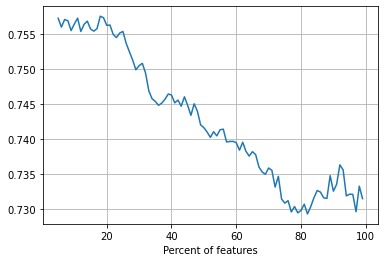

In [30]:
model = LogisticRegression(random_state=0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(train_x, y_train)    
    cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [43]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
selectp = SelectPercentile(percentile=best_score[0]).fit(train_x, y_train)
X_train_sel = selectp.transform(train_x)
X_test_sel = selectp.transform(test_x)

In [44]:
X_train_sel.shape, X_test_sel.shape

((3500, 104), (2482, 104))

### Build Models

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

DNN learning curve 1/10


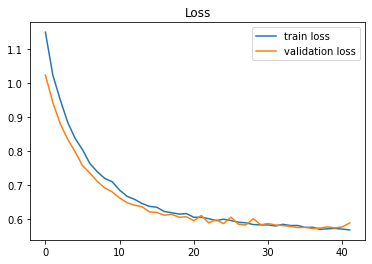

 10%|████████▎                                                                          | 1/10 [00:06<01:01,  6.82s/it]

AUC 0.7518766863462719
DNN learning curve 2/10


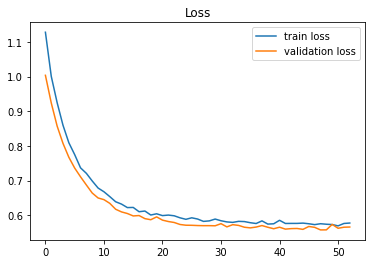

 20%|████████████████▌                                                                  | 2/10 [00:13<00:54,  6.83s/it]

AUC 0.7743181818181818
DNN learning curve 3/10


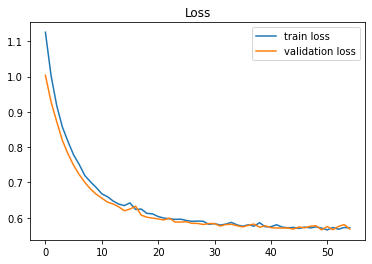

 30%|████████████████████████▉                                                          | 3/10 [00:20<00:48,  6.88s/it]

AUC 0.7667674450931331
DNN learning curve 4/10


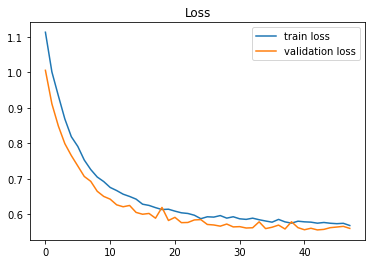

 40%|█████████████████████████████████▏                                                 | 4/10 [00:29<00:44,  7.34s/it]

AUC 0.7612160647401373
DNN learning curve 5/10


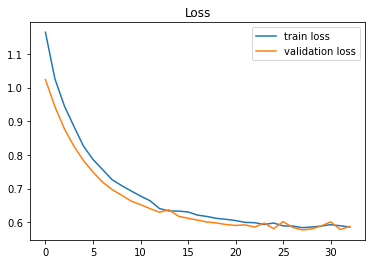

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:33<00:31,  6.37s/it]

AUC 0.7707979626485568
DNN learning curve 6/10


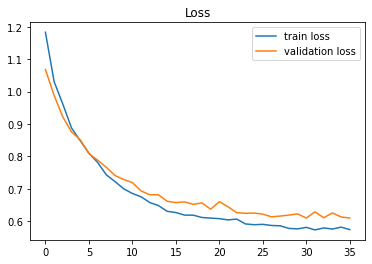

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:39<00:25,  6.36s/it]

AUC 0.7414445457923718
DNN learning curve 7/10


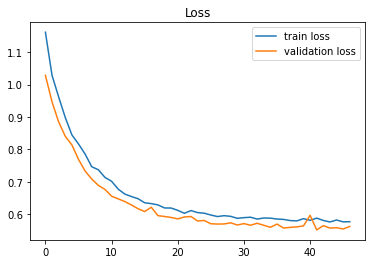

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:47<00:20,  6.75s/it]

AUC 0.7833586384661558
DNN learning curve 8/10


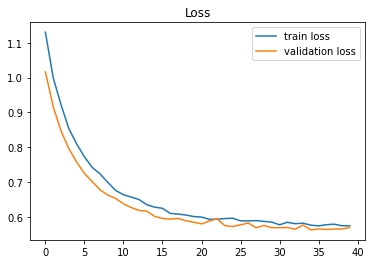

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:53<00:13,  6.68s/it]

AUC 0.7734838121295029
DNN learning curve 9/10


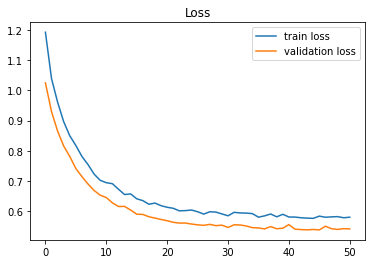

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:01<00:07,  7.12s/it]

AUC 0.7971288888888888
DNN learning curve 10/10


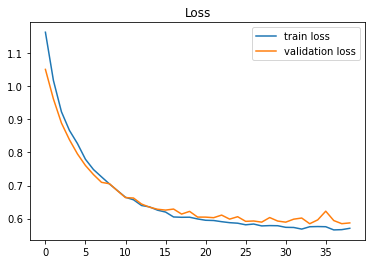

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:08<00:00,  6.82s/it]

AUC 0.763732694400621

Validation Summary:
8    0.797129
6    0.783359
1    0.774318
7    0.773484
4    0.770798
2    0.766767
9    0.763733
3    0.761216
0    0.751877
5    0.741445
dtype: float64
mean=0.76841, std=0.016


In [46]:
# Set hyper-parameters for power mean ensemble 
N = 10
p = 3.5
preds = []
aucs = []

for i in tqdm(range(N)): 
    
    X_train, X_test = X_train_sel, X_test_sel

    ##### STEP 1: Randomize Seed
    
    SEED = i          
    random.seed(SEED)       
    np.random.seed(SEED)     
    tf.random.set_seed(SEED)

    ##### STEP 4: Build a DNN Model

    # Define the Model architecture
    model = Sequential()
    model.add(Dense(32, activation='elu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='elu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    # Train the Model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)
    history = model.fit(train_x, train_y, epochs=100, batch_size=96, 
                        validation_data=(valid_x,valid_y), callbacks=[EarlyStopping(patience=5)], verbose=0)

    print(f'DNN learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    # Make Prediction
    auc = roc_auc_score(valid_y, model.predict(valid_x).flatten())
    aucs.append(auc)
    print('AUC', auc)
    preds.append(model.predict(X_test).flatten())   

### Validate the Models
print('\nValidation Summary:')
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))   

In [48]:
# Power mean ensemble
THRESHOLD = 0.773  # Use only models whose AUC exceeds this value

pred = 0
n = 0
for i in range(N):
    if aucs.iloc[i] > THRESHOLD:
        pred = pred + preds[i]**p 
        n += 1
pred = pred / n    
pred = pred**(1/p)

# Make a submission file
t = pd.Timestamp.now()
fname = f"dae_p{p}n{n}_submit_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
submissions.to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")

'dae_p3.5n4_submit_06142203.csv' is ready to submit.
